# Which Hard Drives are Most Reliable? 

## Goal


The goal of our project is to determine which hard drives are most reliable by classifying and predicting early hard drive failures. 

Hypotheses:
- The 5 SMART (Self-Monitoring, Analysis and Reporting Technology) stats identified by Backblaze will indicate device hard drive failure
- Hard drive fail rates will vary by model 
- Hard drives fail rates will vary by manufacturer 

Summary:
- The 5 SMART stats are reliable indicators of early drive failure
- Failure rates vary by model
- Failure rates vary by manufacturer

In [144]:
# data wrangling
import pandas as pd
import numpy as np

#remove warnings
import warnings
warnings.filterwarnings("ignore")

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# py files
import acquire
import prepare
import explore
import model

# data modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

## Acquire

The raw data is available on Backblaze.com. For this analysis, the hard drive data from 2016 - 2019 is utilized. The files are downloaded to a local computer and then unzipped. The files are renamed to the format, "data_Qx_201x", and placed in a folder titled "data". 

The `acquire.acquire_agg_data` function reads in the data, aggregates it, and returns a Pandas dataframe. 
- Using Spark, a dataframe is created from each directory of csv files. The dataframes are concated together with their common columns. This gives a dataframe with 95 columns and 121,390,247 rows. 
- Backblaze identifies 5 SMART stats that predict hard drive failure (SMART 5, 187, 188, 197, 198). The max value of each of these stats are extracted and the dataframe is aggregated by serial number. This reduces the dataframe to 9 columns and 169,073 rows. 
- The spark dataframe is converted to a Pandas dataframe 
- The Pandas dataframe is saved as "hard_drives_smart_5.csv" for future use

This csv is linked in the README and can be downloaded. If "hard_drives_smart_5.csv" is in the working directory, `acquire.acquire_agg_data` will read from the csv instead recreating the dataframe.  

In [145]:
df = acquire.acquire_agg_data()

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [147]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [148]:
df.describe()

,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
count,1.690730e+05,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6.829480e+12,0.035085,23858.714839,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3.981103e+12,0.183996,13357.230448,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000787e+12,0.000000,13727.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.000787e+12,0.000000,22932.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.200014e+13,0.000000,34866.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.400052e+13,1.000000,90477.000000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


## Prepare

The `prepare.prepare` function reads in the dataframe and applies the following changes:
- Converts capacity column from bytes to terabytes.
- Converts max(smart_9_raw) from hours to years.
- Creates a new column for manufacturer name.
- Renames all columns appropriately.
- Reorders columns for understandability. 

In [149]:
df = prepare.prepare(df)

In [150]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,0.0,NaN,NaN,0.0,0.0


The `prepare.unique` function reads in the dataframe and removes duplicated serial numbers that were created during aggregation.

> Due to aggregation, we have 7,031 duplicate hard drives listed with zero capacity bytes. 

In [151]:
df.capacity_terabytes.value_counts()

 4.0     64886
 12.0    50729
 8.0     26108
-0.0      7031
 3.0      6789
 2.0      4678
 0.5      2607
 6.0      2411
 14.0     1302
 10.0     1255
 1.0       388
 0.3       327
 1.5       267
 0.2       210
 5.0        46
 0.1        39
Name: capacity_terabytes, dtype: int64

In [152]:
# Run the function
df = prepare.unique(df)

In [153]:
# Confirm duplicate hard drives with zero capacity have been removed
df.capacity_terabytes.value_counts()

4.0     64878
12.0    50729
8.0     26106
3.0      6789
2.0      4678
0.5      2607
6.0      2411
14.0     1302
10.0     1255
1.0       388
0.3       327
1.5       267
0.2       210
5.0        46
0.1        32
Name: capacity_terabytes, dtype: int64

## Explore

Questions to answer:
- How do we treat null values?
- What does our data look like?
    - How many different models?
    - How many different manufacturers?
    - How many different capacity sizes?
    - How many models are there for each manufacturer?
    - Are model numbers unique to capacity?
    - Are there any observations that need to be dropped (why, how many)?
- What is a failure?
    - What do failures look like?
    - How is this misleading?
    - How do we define an early failure?
- How do the lifespans of hard drives that have failed compared to hard drives that have not failed?
- How do non-zero SMART stat values compare to among fail and non-fail?
- Does the average age of drive vary by manufacturer? model number?
- Do failure rates vary by model number?
- Determine early failure cutoff by analyzing data.
- Which SMART attributes correlate most strongly with early failure? 
- Which features or combination of features correlate with early failure?

### How do we treat null values?

In [154]:
# Check for null values
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_terabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

In [155]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

In [156]:
df.describe()

,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,162025.000000,162025.000000,161965.000000,161841.000000,104186.000000,1.041760e+05,161831.000000,161831.000000
mean,7.125692,0.036550,2.720621,69.854987,5.996362,3.264917e+08,6.266278,5.913626
std,3.797898,0.187655,1.525815,1393.279910,541.372456,3.014704e+10,452.162209,447.564076
min,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000000,0.000000,1.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,6.000000,0.000000,2.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,12.000000,0.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,14.000000,1.000000,10.300000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


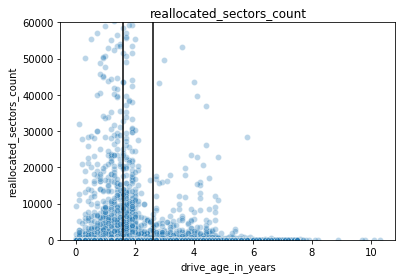

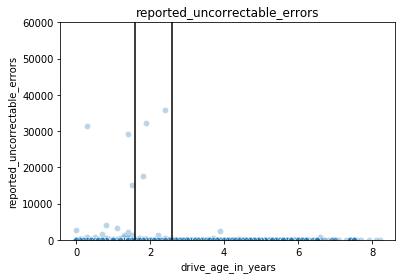

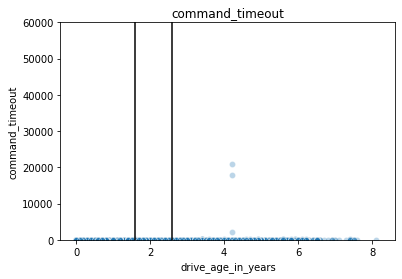

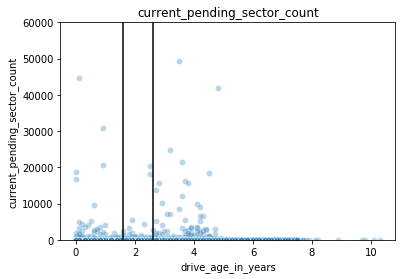

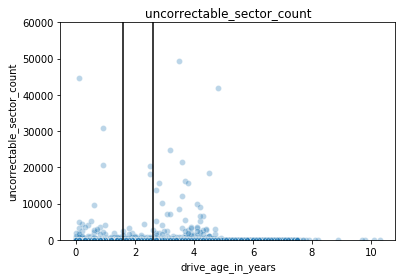

In [157]:
# Create scattplots for SMART attributes
for col in df.columns[6:]:
    sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years, alpha=.3)
    plt.vlines(2.6, ymax=60000, ymin=0)
    plt.vlines(1.6, ymax=60000, ymin=0)
#     plt.yticks([0,60000])
    plt.ylim((0, 60000))
    plt.title(col)
    plt.show()

In [158]:
(df.reallocated_sectors_count != 0).sum()

5786

In [159]:
((df.reallocated_sectors_count != 0) & df.failure == 1).sum()

1910

In [160]:
(df.reallocated_sectors_count == 0).sum()

156239

In [161]:
((df.reallocated_sectors_count == 0) & df.failure == 0).sum()

158013

> For both "reported_uncorrectable_errors" and "command_timeout" the vast majority of values are zero. Therefore, the nulls in these columns are replaced with zeros. For the remaining nulls in "reallocated_sectors_count", "current_pending_sector_count" and "uncorrecteable_sector_count", there are less than 200 for each respective column. Therefore, those rows containing nulls are removed. This is performed in the `prepare.treat_nulls` function.

In [162]:
df = prepare.treat_nulls(df)

In [163]:
# Confirm all nulls have been removed 
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_terabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

> After treating all nulls, the dataframe has 11 columns and 161,830 rows. The data can be further explored. 

### What does our data look like?

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_terabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


#### How many different hard drive models in our dataset? Which are the 5 most popular?

> 97 unique hard drive models. Top 5 hard drive models include 3 Seagate and 2 Hitachi.

In [165]:
df.model.nunique()

97

In [166]:
df['model'].value_counts().head()

ST12000NM0007           38271
ST4000DM000             36156
HGST HMS5C4040BLE640    16314
ST8000NM0055            14810
HGST HUH721212ALN604    10875
Name: model, dtype: int64

#### How many different manufacturers are included in our data set?

> 6 unique manufacturers exist: Hitachi, Seagate, Western Digital, Toshiba, Unknown, and Samsung.

In [167]:
df.manufacturer.nunique()

6

In [168]:
df.manufacturer.unique()

array(['Hitachi', 'Seagate', 'Western Digital', 'Toshiba', 'Unknown',
       'Samsung'], dtype=object)

#### How many different capacity sizes exist for the hard drives in our dataset?

> 15 unique hard drive capacity sizes after rounding to the nearest tenth of a terabyte.

In [169]:
df.capacity_terabytes.nunique()

15

In [170]:
df.capacity_terabytes.unique()

array([ 4. ,  3. ,  8. ,  0.5,  6. ,  2. ,  1. ,  0.1, 12. , 10. , 14. ,
        1.5,  0.2,  0.3,  5. ])

#### How many hard drives exist for each manufacturer?

> Seagate and Hitachi are the most popular manufacturers. Samsung and Unknown only have 1 hard drive each. These hard drives should be dropped from our dataset. 

In [171]:
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Samsung,1
Seagate,105012
Toshiba,2573
Unknown,1
Western Digital,2826


#### Remove Samsung and Unknown hard drives

The `explore.remove_manufacturer` function reads in the dataframe and removes the two manufacturers with low value counts.

In [172]:
df = explore.remove_manufacturers(df)

In [173]:
# Confirm low count manufacturers have been removed
df[['model', 'manufacturer']].groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Seagate,105012
Toshiba,2573
Western Digital,2826


#### Are model numbers unique to capacity?

> Yes, model numbers are unique to capacity. We ask this question to ensure there are not any hard drive models that have different capacities. 

In [174]:
# create new df to group models with their capacity terabytes
model_terabytes = df[['model', 'capacity_terabytes']]

In [175]:
# count unique models
model_terabytes.model.nunique()

95

In [176]:
# group unique model and unique terabytes combinations
unique_model_terabytes = len(model_terabytes.groupby(['model', 'capacity_terabytes']).count())

In [177]:
# compare the length of unique model and gigabytes combinations to the count of unique models, must equal a match.
unique_model_terabytes == model_terabytes.model.nunique()

True

#### Does the average hard drive age vary by manufacturer? By model?

In [178]:
# Average drive age by manufacturer
manufacturers = df[['manufacturer', 'drive_age_in_years']].groupby('manufacturer',sort=True).mean()
manufacturers

,drive_age_in_years
manufacturer,
Hitachi,3.057432
Seagate,2.557938
Toshiba,1.611698
Western Digital,3.765322


Text(0.5, 1.0, 'Manufacturers by Average Drive Age')

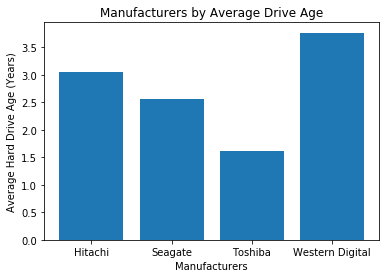

In [179]:
# Plot of Manufacturers by Average Drive Age
ax1 = plt.bar(x= manufacturers.index ,height=manufacturers.drive_age_in_years)
plt.xlabel('Manufacturers')
plt.ylabel('Average Hard Drive Age (Years)')
plt.title('Manufacturers by Average Drive Age')

In [180]:
# Drive age aggregated by model number and sorted. Top 10 models returned
model_avg_age = df[['model', 'drive_age_in_years']].groupby('model',sort=True).mean().sort_values('drive_age_in_years', ascending = False)
model_avg_age.head()

,drive_age_in_years
model,
WDC WD800LB,10.300000
WDC WD800BB,9.240000
Hitachi HDT725025VLA380,7.800000
WDC WD3200AAKS,6.800000
WDC WD10EACS,6.586667


Text(0.5, 1.0, 'Models by Average Drive Age')

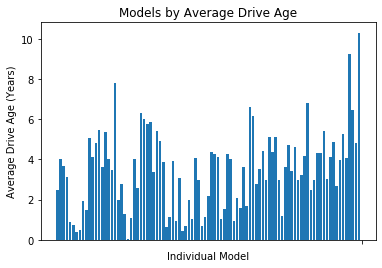

In [181]:
# Plot of Models by Average Drive Age
mod = model_avg_age.groupby('model').mean()
ax2 = plt.bar(x= mod.index ,height=mod.drive_age_in_years)
plt.xticks('')
plt.xlabel('Individual Model')
plt.ylabel('Average Drive Age (Years)')
plt.title('Models by Average Drive Age')

> Variance in drive age is seen in both the manufacturers and model numbers. 

### What is a hard drive failure?

According to Backblaze, a hard drive failure occurs when a drive stops spinning, won’t stay as a member of a RAID array, or demonstrates continuous degradation over time as informed by SMART stats and other system checks.

Because we aggregate the failur column by the max value, a "0" signifies a hard drive that has yet to fail, and a "1" signifies a hard drive that has failed. 

#### What do failures look like? 

#### How do the lifespans of hard drives that have failed compared to hard drives that have not failed?

In [182]:
# create new dfs with hard drives that have failed, and hard drives that have not failed 
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

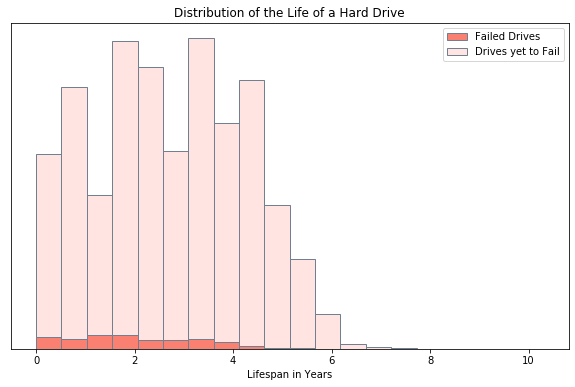

In [183]:
plt.figure(figsize=(10,6))
plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], stacked=True, bins=20,
         edgecolor='slategrey', color=['salmon', 'mistyrose'])
plt.legend(["Failed Drives","Drives yet to Fail"])
plt.title("Distribution of the Life of a Hard Drive")
plt.xlabel("Lifespan in Years")
plt.yticks([])
plt.show()

#### How is this misleading?
- Failures do not take into account the lifespan of the hard drive. It is important to realize that all hard drives, given enough time, will eventually fail. For example, if a hard drive fails after 10 years of continual operation, is it fair to say that drive "failed"? Therefore, our focus should be on drives that fail before reaching their average lifespan. We need to identify early failures.  
- Failures include not only drives that have failed, but also drives that have yet to fail but show signs of failing soon. Our goal is to determine the reliability of hard drives. Therefore, we are ok with classifying imminently failing drives as failures. 

#### How do we define an early failure? 

The goal of the project is to determine which hard drives are more prone to early failures. Looking at the lifespan of all hard drives, a hard drive that fails within the first quartile of all life spans, is labeled as an early failure.

In [184]:
df[['drive_age_in_years']].describe()

,drive_age_in_years
count,161828.000000
mean,2.722680
std,1.524778
min,0.000000
25%,1.600000
50%,2.600000
75%,4.000000
max,10.300000


> A cut-off age of 1.6 years is utilized.

The `explore.early_failure` function creates a column in the dataframe that identifies drives that are early failures.

In [185]:
df.manufacturer.value_counts()

Seagate            105012
Hitachi             51417
Western Digital      2826
Toshiba              2573
Name: manufacturer, dtype: int64

In [186]:
df.failure.value_counts()

0    155917
1      5911
Name: failure, dtype: int64

In [187]:
df.describe()

,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,161828.000000,161828.000000,161828.000000,161828.000000,161828.000000,1.618280e+05,161828.000000,161828.000000
mean,7.133777,0.036526,2.722680,69.860599,3.638474,2.101775e+08,6.266388,5.913736
std,3.793097,0.187597,1.524778,1393.335731,425.113452,2.418856e+10,452.166400,447.568224
min,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000000,0.000000,1.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,6.000000,0.000000,2.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,12.000000,0.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,14.000000,1.000000,10.300000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


In [188]:
df = explore.early_failure(df,2.6)

In [189]:
df.early_failure.value_counts()

0    157842
1      3986
Name: early_failure, dtype: int64

#### Removing young non-failing hard drives

Hard drives that are currently functioning properly, but have yet reached the established cut-off age will be removed from this analysis. These hard drives have not been powered on long enough to give significant stats of a reliable drive. The `explore.old_or_fail` function drops rows containing drives that have not failed and are not older than the cut off age (1.6 years).

In [190]:
df = explore.old_or_fail(df,2.6)

In [191]:
df.shape

(83940, 12)

In [192]:
df.early_failure.value_counts()

0    79954
1     3986
Name: early_failure, dtype: int64

In [193]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count',
       'early_failure'],
      dtype='object')

> After defining early failures and removing young non-failing drives, the dataframe has 12 columns and 121,900 rows. The data can be further explored. 

#### How do non-zero SMART stat values compare in failed hard drives and non-failed hard drives

In [194]:
# misty

#### Do early failure rates vary by model number?

In [195]:
# aggegrate by early failure, drive age, and add a total count
agg_model = df.groupby(['model']).agg({'early_failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'early_failure':'early_failures', 'model':'total_drives', 'drive_age_in_years':'average_age_in_years'}, inplace=True)

# add an early failure rate column
agg_model['early_failure_rate_percent'] = agg_model['early_failures'] / agg_model['total_drives'] * 100
agg_model.sort_values('early_failures', ascending = False)

,early_failures,total_drives,average_age_in_years,early_failure_rate_percent
model,,,,
ST4000DM000,1498,34901,3.947474,4.292141
ST12000NM0007,1104,1104,1.046830,100.000000
ST8000NM0055,383,442,1.395249,86.651584
ST8000DM002,276,9928,3.018433,2.780016
HGST HMS5C4040BLE640,197,10920,3.511181,1.804029
TOSHIBA MQ01ABF050,112,249,2.259839,44.979920
HGST HMS5C4040ALE640,59,7673,3.842408,0.768930
ST500LM012 HN,41,603,3.475456,6.799337
ST4000DM001,34,34,0.244118,100.000000


In [196]:
(agg_model.early_failure_rate_percent > 50).sum()

18

Text(0.5, 0, 'Failure Rate (%)')

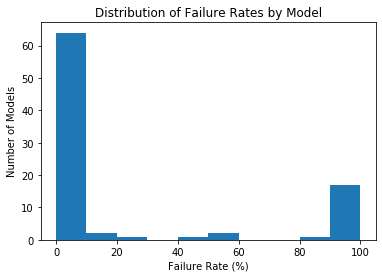

In [197]:
plt.hist(agg_model.early_failure_rate_percent)
plt.title("Distribution of Failure Rates by Model")
plt.ylabel("Number of Models")
plt.xlabel("Failure Rate (%)")
#plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

In [198]:
df.shape

(83940, 12)

(0, 70000)

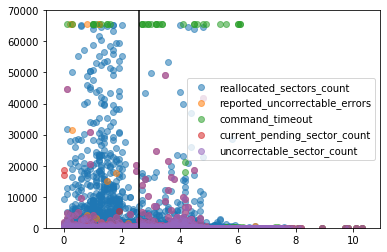

In [199]:
for col in df.columns[6:-1]:
    plt.scatter(y=df[col], x=df.drive_age_in_years, label=col, alpha=.55)
plt.legend(loc='best')
plt.vlines(2.6, 0, 70_000)
plt.ylim((0, 70_000))

In [200]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count',
       'early_failure'],
      dtype='object')

In [201]:
# create new dfs with hard drives that have failed, and hard drives that have not failed 
df_early_fails = df [df.early_failure == 1]
df_not_early_fails = df [df.early_failure == 0]
df_no_fails = df [df.failure == 0]

Text(0.5, 1.0, 'Early Failures')

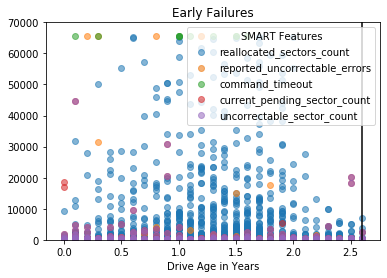

In [202]:
for col in df.columns[6:-1]:
    plt.scatter(y=df_early_fails[col], x=df_early_fails.drive_age_in_years, label=col, alpha = .55)
plt.legend(title = 'SMART Features')
plt.vlines(2.6, 0, 70_000)
plt.ylim((0, 70_000))
plt.xlabel("Drive Age in Years")
plt.title('Early Failures')

Text(0.5, 1.0, 'Non Failures')

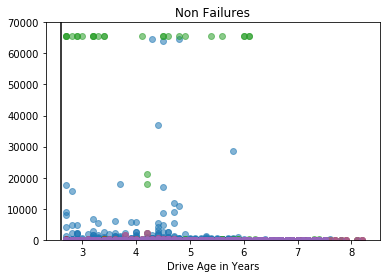

In [203]:
for col in df.columns[6:-1]:
    plt.scatter(y=df_no_fails[col], x=df_no_fails.drive_age_in_years, label=col, alpha = .55)
#plt.legend()
plt.vlines(2.6, 0, 70_000)
plt.ylim((0, 70_000))
plt.xlabel("Drive Age in Years")
plt.title('Non Failures')

Text(0.5, 1.0, 'Non Early Failures')

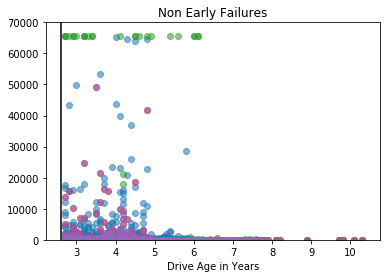

In [204]:
for col in df.columns[6:-1]:
    plt.scatter(y=df_not_early_fails[col], x=df_not_early_fails.drive_age_in_years, label=col, alpha = .55)
#plt.legend()
plt.vlines(2.6, 0, 70_000)
plt.ylim((0, 70_000))
plt.xlabel("Drive Age in Years")
plt.title('Non Early Failures')

#### Which SMART attributes correlate most strongly with early failure?

The five SMART stats being presented count the occurrence of different types of errors that can occur in hard drives. For each type a count of above zero indicates that a hard drive should be replaced quickly due to a risk of failure.

In [205]:
smart_stats_5 = df.columns[6:11]
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

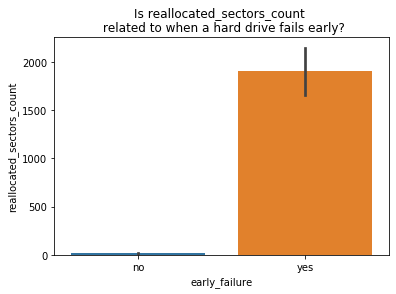

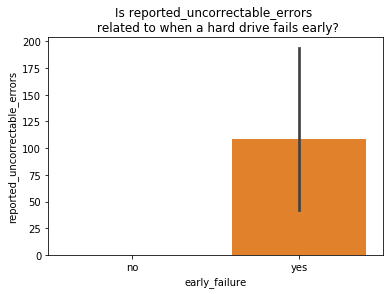

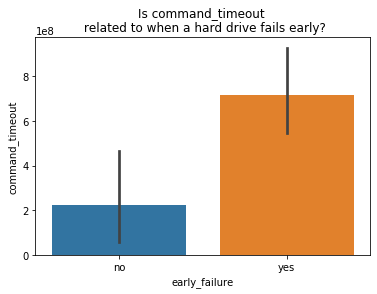

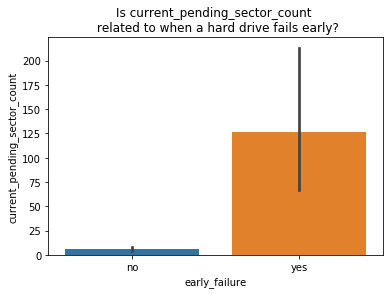

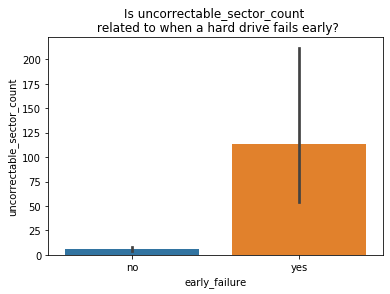

In [206]:
for stat in smart_stats_5:
    sns.barplot(df.early_failure,df[stat])
    plt.title("Is {} \n related to when a hard drive fails early?".format(stat))
    plt.xticks([0,1],["no","yes"])
    plt.show()

> Because these errors occur far more frequently in early failures than in non-early failures, all of these SMART seem to be a good indicator for early failures. 

#### Which manufacturer produces the most early failures?

> Of the four manufacturers being analyzed, Toshiba produces significantly more early failures.

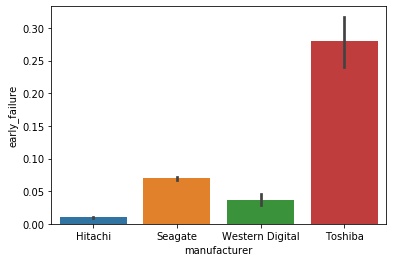

In [207]:
sns.barplot(df.manufacturer,df.early_failure)
plt.show()

#### Does drive capacity size correlate with failure rates? 

> Failure rate dramatically increases in drives that have a 14 terabytes capacity.

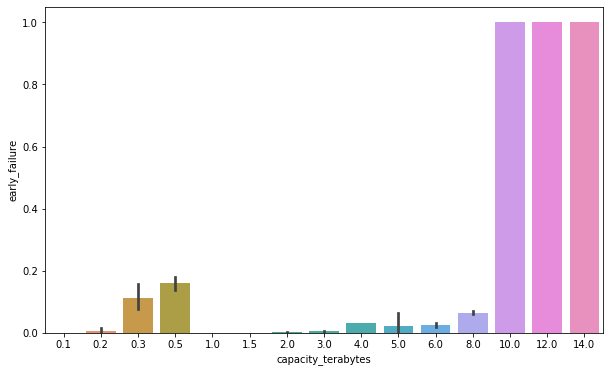

In [208]:
# sns.set(rc={'figure.figsize':(10,6)})
plt.figure(figsize=(10,6))
sns.barplot(df.capacity_terabytes,df.early_failure)
plt.show()

# Pickle Test

In [209]:
import pickle

example_dict = {1:"6",2:"2",3:"f"}

pickle_out = open("dict.pickle","wb")
pickle.dump(example_dict, pickle_out)
pickle_out.close()

In [210]:
pickle_in = open("dict.pickle","rb")
example_dict = pickle.load(pickle_in)

In [211]:
example_dict

{1: '6', 2: '2', 3: 'f'}

## Model

In [212]:
# Split
X_train, X_test, y_train, y_test = model.split_my_data(df)

In [213]:
# Make features binary
df = explore.make_binary_values(df)

In [214]:
X_train.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_terabytes',
       'reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

In [215]:
# One hot encode manufacturer column
X_train, X_test = model.encode_hot(X_train, X_test, 'manufacturer')

# Model

In [216]:
X_train.columns

Index(['serial_number', 'model', 'capacity_terabytes',
       'reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count', 'Hitachi', 'Seagate', 'Toshiba',
       'Western Digital'],
      dtype='object')

In [217]:
# drop non numeric columns
X_train.drop(columns={'serial_number','model'}, inplace = True)
X_test.drop(columns={'serial_number','model'}, inplace = True)

In [218]:
# Run knn model, cutoff = 2.6 years
score = []
n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors, weights = 'uniform')


In [219]:
knn.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [220]:
train_pred=knn.predict(X_train)


In [ ]:
score.append(recall_score(y_train, train_pred))

[[63386   577]
 [ 1478  1711]]
The best recall is at k= 0 with a recall score of 0.5365318281592976


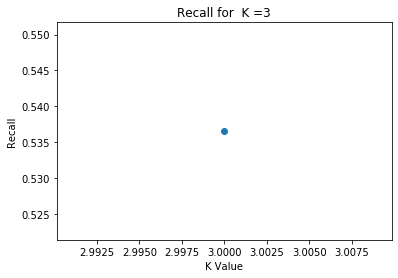

In [73]:
# Evaluate
plt.figure()
plt.xlabel('K Value')
plt.ylabel('Recall')
plt.scatter(n_neighbors, score)
plt.title(f'Recall for  K ={n_neighbors}')
print(confusion_matrix(y_train,train_pred))
print(f'The best recall is at k= {score.index(max(score))} with a recall score of {max(score)}')

In [74]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     63963
           1       0.75      0.54      0.62      3189

    accuracy                           0.97     67152
   macro avg       0.86      0.76      0.80     67152
weighted avg       0.97      0.97      0.97     67152



In [139]:
cucumber = classification_report(y_train, train_pred)

In [140]:
pickle_out = open("cucumber.pickle","wb")
pickle.dump(cucumber, pickle_out)
pickle_out.close()

In [141]:
variable_name = open("cucumber.pickle","rb")
cucumber = pickle.load(variable_name)

In [143]:
print(cucumber)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     63963
           1       0.75      0.54      0.62      3189

    accuracy                           0.97     67152
   macro avg       0.86      0.76      0.80     67152
weighted avg       0.97      0.97      0.97     67152

